<a href="https://colab.research.google.com/github/zj71/Computer-Vision/blob/main/%E2%80%9CCV_Lab_Session_9_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab Introduction
This lab will introduce you to generative adversarial networks in [TensorFlow](https://www.tensorflow.org/). This is loosely based on the tutorials [here](https://www.tensorflow.org/tutorials/generative/dcgan). TensorFlow has [excellent documentation](https://www.tensorflow.org/api_docs/python/tf/keras). If you're running this in Colab, you can improve the speed of execution by selecting : Runtime | Change Runtime Type and selecting GPU (graphics processing unit) or [TPU](https://en.wikipedia.org/wiki/Tensor_Processing_Unit)

#Imports
We need to import tensorflow, commonly named as tf.
We also use tf.keras and tf.keras.layers a lot as well, so we rename those.

In [ ]:
import tensorflow as tf
keras = tf.keras
layers = tf.keras.layers
# Include numpy for basic stuff
import numpy as np
# matplotlib allows us to visualise our data.
import matplotlib.pyplot as plt
# Import a library for displaying models
from IPython.display import Image

## Let's get some data
For this lab we're going to initially look at the [MNIST handwritten digit dataset](http://yann.lecun.com/exdb/mnist/), as we did in the FML CNN lab. This dataset has been explored for a wide variety of models and serves as a standard benchmark for comparing/trying things. In the main part of this lab we do not need the image labels, just the data. The labels could be useful for the extension task of making a *conditional* GAN.

1. Look at the size and shape of the data elements. How large are the images? 
2. Use [plt.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html?highlight=imshow#matplotlib.pyplot.imshow) to visualise some examples from the data. Check what the corresponding label for each example is.

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,) [0 1 2 3 4 5 6 7 8 9]


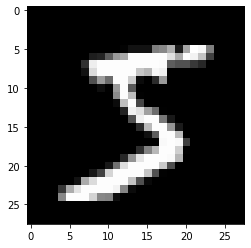

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# Print the shapes of the array and the unique label 
print(x_train.shape, y_train.shape, np.unique(y_test))
# Pick an example index
example_idx = 0
plt.imshow(x_train[example_idx,...],cmap='gray')
# Print the label
plt.show()

# Prepare the data
Again, we put the image data (which is normally from 0-255) into floating point numbers and scale so the values are between 0 and 1.
We also don't need the test set for anything (why?), so we can append it to the training set.

In [ ]:
# Divide the image data to put it in the right range and convert to floating point numbers
x_train = x_train.astype("float32") / 255
# Preprocess the test data the same way
x_test = x_test.astype("float32") / 255

# Stick the data together
x_data = np.concatenate([x_train, x_test], axis=0)

# Reshape to (-1, im_height, im_width, 1)
x_data = np.reshape(x_data, (-1, 28, 28,1))

# We're not interested in the labels, but if we were...
# Convert the labels to floating point
y_train = y_train.astype("float32")
y_test = y_test.astype("float32")
y_data = np.concatenate([y_train, y_test], axis=0)

# Define the BATCH_SIZE as a variable as we need it later
BATCH_SIZE = 256
# Prepare the training dataset into batches and shuffle the examples
train_dataset = tf.data.Dataset.from_tensor_slices(x_data)
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)

# Create the generator
This function takes a vector of numbers of length z_size as input and produces an image! 
+ Trace through the function definition - try and fill in the missing code.
+ Why do we initially map z into a 7x7 image? **hint** the original images have size 28x28.
+ Are there any layers here that you've never seen before? What are they? what do you think they do?
+ Instead of using [layers.UpSampling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D) and [layers.Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) you could use a [layers.Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose). The approach taken here is generally considered to produce less artefacts.



In [ ]:
def make_generator(z_size=32, layer_sizes=[256, 128, 64]):
  """
  z_size specifies the latent variable dimension
  layer_sizes: is a list containing the number of channels at each stage in the generator
  """
  # Note that the Input size relates to the size of each instance
  inputs = keras.Input(shape=(z_size,), name="z")
  net = inputs

  # We first need to increase the size of our Tensor to reshape it into an image and
  # apply some convolutions. Let's map our z into a 7x7xlayers[0].  
  net = layers.Dense(7*7*layer_sizes[0],use_bias=False)(net)

  # The Dense lay produces a new vector, which we can reshape to look like an image.
  # Reshape to the right image size
  net = layers.Reshape((?,?,layer_sizes[0]))(net)

  # Apply batch normalisation followed by leaky relu (a slight variation on the relu activation function)
  net = layers.BatchNormalization(scale=False, center=False)(net)
  net = layers.LeakyReLU()(net)
  # Let's do our first convolution
  net = layers.Conv2D(layer_sizes[1], 5, padding='same', use_bias=False)(net)
  net = layers.BatchNormalization(scale=False, center=False)(net)
  net = layers.LeakyReLU()(net)

  # We want to grow the size of the image, let's do this by applying bilinear upsampling
  net = layers.UpSampling2D(size=(2,2))(net)

  # Followed by convolution, batch norm and relu again
  net = layers.Conv2D(layer_sizes[2], 5, padding='same', use_bias=False)(net)
  net = layers.BatchNormalization(scale=False, center=False)(net)
  net = layers.LeakyReLU()(net)

    # We want to grow the size of the image, let's do this by applying bilinear upsampling
  net = layers.UpSampling2D(size=(2,2))(net)

  # We do one final convolution to produce the final image (use a sigmoid to put the values in the correct range)
  net = layers.Conv2D(1, 5, padding='same', activation='sigmoid')(net)
  

  return keras.Model(inputs=inputs, outputs=net)

# Test the function works - but don't save the result yet
make_generator()

# Create the discriminator
This is just an image classifier, which will be used to identify if the images are from the training dataset or from the generator.



In [ ]:
def make_discriminator(layer_sizes=[64, 128]):
  """
  layer_sizes: list containing the number of channels at each stage of the discriminator
  """
  # Note that the Input size relates to the size of each instance
  inputs = keras.Input(shape=(28,28,1), name="image")
  net = inputs

  # We can also define the layer object, and store it in a Python variable and call it later
  # We're more likely to want to do this for layers that contain model weights
  conv1 = layers.Conv2D(filters=layer_sizes[0], kernel_size=5, padding='same', strides=(2,2))
  net = conv1(net)
  # Dropout might help a bit
  #net = layers.Dropout(0.1)(net)
  net = layers.LeakyReLU()(net)

  conv2 = layers.Conv2D(filters=layer_sizes[1], kernel_size=5, padding='same', strides=(2,2))
  net = conv2(net)
  # Dropout might help a bit
  #net = layers.Dropout(0.1)(net)
  net = layers.LeakyReLU()(net)


  # We need to flatten the spatial dimensions before putting it through the dense layers
  net = layers.Flatten()(net)
  dense1 = layers.Dense(units=1)
  # Apply the dense layer
  net = ?

  return keras.Model(inputs=inputs, outputs=net)

make_discriminator()


# Create our models
We need to create our generator and discriminator models. 
+ Draw an image of what the untrained generator predicts for a random input vector.
+ Examine the output of the untrained discriminator on that image.

In [ ]:
noise_dim = 64

generator = make_generator(z_size=noise_dim, layer_sizes=[256, 128, 64])

noise = tf.random.normal([1, noise_dim])
generated_image = generator(?, training=False)

plt.imshow(?, cmap='gray')

# Print the output of the discriminator
discriminator = make_discriminator(layer_sizes=[64, 128])
print(discriminator(?))

# Define the model losses
You don't need to write anything here - this is just where we define the losses for training the generator and the discriminator.
+ Trace through the code, what is the difference between the discriminator and generator losses?
+ An important thing to note is that we have different optimizers for our generator and discriminator. The learning rates are defined here, which are very important for training.

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Define the optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Define the training loop
GANs are a bit different to train - we don't have a fixed loss function we're minimising as the models are competing against each other. The code below breaks down each iteration of training the generator and the discriminator.
+ Trace through the code. What do you think a "GradientTape" does?

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled". Making it faster to call thereafter
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    # Create a pair of gradient tapes
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # Generate some fake data from the noise input
      generated_images = generator(noise, training=True)
      # Call the discriminator on the real images
      real_output = discriminator(images, training=True)
      # Call the discriminator on the generated images
      fake_output = discriminator(generated_images, training=True)
      # Calculate the losses
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    # Calculate the gradient of the losses for the right variables
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Update the model variables
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    # Return the losses
    return gen_loss, disc_loss

# Train the model
Go through the dataset for a fixed number of epochs. Let's visualise the models progress as we go. After about 10 mins you should see the images start to appear like real images.
+ GANs are notoriously tricky to train and there's a lot of variables that might affect our results. These include the optimizer learning rates, the generator/discriminator architectures, the batch size and the dimensionality of the noise variable z. Have an experiment with some of these factors


In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):

    for idx, image_batch in enumerate(dataset):
      losses = train_step(image_batch)
      # Every N btaches, print the losses of that batch and draw some example images
      if idx % 10 == 0:
        print(losses)
        noise = tf.random.normal([3, noise_dim])
        generated_image = generator(noise, training=False)
        plt.subplot(131)
        plt.imshow(generated_image[0, :, :, 0], cmap='gray')
        plt.subplot(132)
        plt.imshow(generated_image[1, :, :, 0], cmap='gray')
        plt.subplot(133)
        plt.imshow(generated_image[2, :, :, 0], cmap='gray')
        plt.show()

# 
train(train_dataset, 30)

# Extensions
1. Once you've trained a model that works reasonably well. Generate an image for a random noise sample. Then generate another noise sample, and visualise how the images change as you change the latent values.
1. Make a conditional GAN (i.e. where you can specify the label of the data). Look at this [example paper](https://arxiv.org/abs/1411.1784) for some ideas.
2. Rather than regular convolutional layers. Try using residual convolutional blocks, which we talked about in the FML lectures. You can see an idea for implementing it (ResnetIdentityBlock) in the tutorial [here](https://www.tensorflow.org/tutorials/customization/custom_layers#implementing_custom_layers)
3. Experiment with alternative datasets such as [FashionMNIST](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist), which is similar to MNIST, but contains grayscale images of fashion items. Alternatively, look at a more complex (but still low-resolution) image dataset. [CIFAR 10](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10) or [CIFAR 100](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar100). Note that this dataset has images at (32x32,3) so you'll need to adjust the architecture (how?).
4. We talked about CycleGAN in the lecture. Look at the [TensorFlow CycleGAN tutorial](https://www.tensorflow.org/tutorials/generative/cyclegan)
5. Implement a residual block for the generator/discriminator, you could try sub-classing the [Layer base class](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer)
6. Learn how to use [Tensorboard](https://www.tensorflow.org/tensorboard), an excellent tool for visualising your model training, which you can either run from [Colab](https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb) or install on your local machine
7. Following the example in [this tutorial](https://www.tensorflow.org/tutorials/generative/dcgan) make a set of animations showing how the images change for a fixed set of random seeds over time.